In [56]:
import torch
import torch.nn as nn
import os
import stim
import numpy as np
from tqdm import tqdm
from typing import List
from dataclasses import dataclass
import matplotlib.pyplot as plt

In [57]:
@dataclass
class DEM_Matrices:
    check_matrix: torch.Tensor
    logical_matrix: torch.Tensor
    llrs: torch.Tensor

def DEM_to_matrices(DEM: stim.DetectorErrorModel) -> DEM_Matrices:

    priors = np.zeros(DEM.num_errors)
    check_matrix = np.zeros((DEM.num_detectors, DEM.num_errors))
    logical_matrix = np.zeros((DEM.num_observables, DEM.num_errors))
    
    e = 0
    
    for instruction in DEM.flattened():
        
        if instruction.type == "error":
            
            detectors: List[int] = []
            logicals: List[int] = []
            t: stim.DemTarget
            p = instruction.args_copy()[0]
            for t in instruction.targets_copy():
                if t.is_relative_detector_id():
                    detectors.append(t.val)
                elif t.is_logical_observable_id():
                    logicals.append(t.val)

            priors[e] = p
            check_matrix[detectors, e] = 1
            logical_matrix[logicals, e] = 1
            
            e += 1
            
        elif instruction.type == "detector":
            pass
        elif instruction.type == "logical_observable":
            pass
        else:
            raise NotImplementedError()
    
    check_matrix = torch.tensor(check_matrix, dtype=torch.int)
    logical_matrix = torch.tensor(logical_matrix, dtype=torch.int)
    priors = torch.tensor(priors, dtype=torch.float32)
    
    llrs = torch.log((1 - priors) / priors)
    
    return DEM_Matrices(
        check_matrix=check_matrix,
        logical_matrix=logical_matrix,
        llrs=llrs
    )

In [58]:
class Nbp_decoder(nn.Module):
    
    def __init__(self,
                 circuit: stim.Circuit,
                 layers: int = 20,
                 weights: str = None,
                 loss_function: str = 'binary_cross_entropy',
                 batch_size: int = 1):
        
        super().__init__()
        
        self.device = 'cpu'
        
        self.loss_fucntion = loss_function
        
        if circuit:
        
            self.circuit = circuit
            self.dem = self.circuit.detector_error_model(decompose_errors=False)
            
            self.matrices = DEM_to_matrices( self.dem )
            
            self.H = self.matrices.check_matrix
            self.L = self.matrices.logical_matrix
            self.llrs = self.matrices.llrs
    
        self.m = self.H.size()[0]
        self.n = self.H.size()[1]
        
        self.layers = layers
        self.batch_size = batch_size
        
        if not weights:
            self.ini_weights_as_one()
        else:
            self.load_weights(weights, self.device)
            
    def ini_weights_as_one(self):
        
        self.weights_llr = []
        self.weights_de = []
        
        self.marg_weights_llr = []
        self.marg_weights_de = []
        
        self.rhos = []
        self.residual_weights = []
        
        for _ in range(self.layers):
            
            self.weights_de.append(torch.ones_like(self.H, dtype=float, requires_grad=True, device=self.device))
            self.weights_llr.append(torch.ones_like(self.llrs, dtype=float, requires_grad=True, device=self.device))
            
            self.marg_weights_de.append(torch.ones_like(self.H, dtype=float, requires_grad=True, device=self.device))
            self.marg_weights_llr.append(torch.ones_like(self.llrs, dtype=float, requires_grad=True, device=self.device))
        
        self.residual_weights.append(torch.zeros(self.layers, dtype=float, requires_grad=True, device=self.device))
        
        self.rhos.append(torch.ones(self.layers, dtype=float, requires_grad=True, device=self.device))
        with torch.no_grad():
            normalised_rhos = [rho / self.layers for rho in self.rhos]
        self.rhos = normalised_rhos
                
    def save_weights(self, path: str):
    
        file_de = 'weights_de.pt'
        file_llr = 'weights_llr.pt'
        
        file_marg_de = 'marg_weights_de.pt'
        file_marg_llr = 'marg_weights_llr.pt'
        
        file_residuals = 'residual_weights.pt'
        file_rhos = 'rhos.pt'
        
        torch.save(self.weights_de, os.path.join(path, file_de))
        torch.save(self.weights_llr, os.path.join(path, file_llr))
        
        torch.save(self.marg_weights_de, os.path.join(path, file_marg_de))
        torch.save(self.marg_weights_llr, os.path.join(path, file_marg_llr))
        
        torch.save(self.residual_weights, os.path.join(path, file_residuals))
        torch.save(self.rhos, os.path.join(path, file_rhos))
        
        print(f'Weigths saved as {file_de}, {file_llr}, {file_marg_de}, {file_marg_llr}, {file_residuals}, {file_rhos} at {path}.')
            
    def load_weights(self, path: str):
        
        file_de = 'weights_de.pt'
        file_llr = 'weights_llr.pt'
        
        file_marg_de = 'marg_weights_de.pt'
        file_marg_llr = 'marg_weights_llr.pt'
        
        file_residuals = 'residual_weights.pt'
        file_rhos = 'rhos.pt'
        
        self.weights_de = torch.load(os.path.join(path, file_de))
        self.weights_llr = torch.load(os.path.join(path, file_llr))
        
        self.marg_weights_de = torch.load(os.path.join(path, file_marg_de))
        self.marg_weights_llr = torch.load(os.path.join(path, file_marg_llr))
        
        self.residual_weights = torch.load(os.path.join(path, file_residuals))
        self.rhos = torch.load(os.path.join(path, file_rhos))
        
    def update_error_nodes(self, incoming_messages, weights_llr, weights_de):
        
        outgoing_messages = torch.zeros((self.batch_size, self.m, self.n))
        
        weighted_messages = incoming_messages * weights_de
        
        outgoing_messages += self.H * self.llrs * weights_llr
        outgoing_messages += torch.sum(weighted_messages, dim=1, keepdim=True)
        outgoing_messages *= self.H
        outgoing_messages -= incoming_messages
        
        return outgoing_messages
    
    def update_detector_nodes(self, incoming_messages, syndromes):
        
        divider = torch.tanh(incoming_messages/2)
        divider = torch.where(divider == 0, torch.tensor(1.0), divider)
        
        multiplicator = torch.pow(-1, syndromes)
        multiplicator = multiplicator*self.H
        
        outgoing_messages = 2*torch.atanh(torch.prod(divider, dim=2, keepdim=True) / divider)
        outgoing_messages *= multiplicator
        
        return outgoing_messages
    
    def compute_beliefs(self, detector_to_error_messages, marg_weights_llr, marg_weights_de):
        
        weighted_messages = detector_to_error_messages * marg_weights_de
        
        beliefs = torch.sum(weighted_messages, dim=1)
        beliefs += self.llrs*marg_weights_llr
        
        return beliefs
    
    def infer_predictions(self, beliefs):
        
        predictions = torch.zeros_like(beliefs, dtype=float)
        predictions[beliefs < 0] = 1
        
        return predictions
    
    def soft_vectors(self, beliefs):
        
        sigmoid = nn.Sigmoid()
        soft_vectors = sigmoid(-beliefs)
        
        return soft_vectors
    
    def loss(self, beliefs, errors):
        
        softplus = nn.Softplus(beta=1.0, threshold=50)
        sigmoid = nn.Sigmoid()
        
        if self.loss_fucntion == 'binary_cross_entropy':
            
            loss = softplus(beliefs)
            loss -= (1 - errors) * beliefs
            loss = torch.sum(loss, dim=1)
            
        if self.loss_fucntion == 'He=s':
            
            e = errors + sigmoid(-beliefs)
            loss = self.H.double() @ e.T
            loss = torch.abs(torch.sin(np.pi * loss / 2))
            loss = torch.sum(loss, dim=0)
            
        return loss
    
    def forward(self, syndromes, errors):
        
        loss_array = torch.zeros(self.batch_size, self.layers).float()
        
        messages_en_to_dn = torch.zeros((self.batch_size, self.m, self.n))
        messages_dn_to_en = torch.zeros((self.batch_size, self.m, self.n))
        
        for i in range(self.layers):
            
            messages_en_to_dn = self.update_error_nodes(messages_dn_to_en, self.weights_llr[i], self.weights_de[i])
            residual_messages = self.residual_weights[0][i] * messages_dn_to_en
            messages_dn_to_en = self.update_detector_nodes(messages_en_to_dn, syndromes) + residual_messages
            beliefs = self.compute_beliefs(messages_dn_to_en, self.marg_weights_llr[0], self.marg_weights_de[0])
            
            loss_array[:, i] = self.loss(beliefs, errors) * self.rhos[0][i]

        loss_array = loss_array
        loss = torch.sum(loss_array, dim=1)
        loss = torch.sum(loss, dim=0) / self.batch_size
        
        return loss
    
    def decode(self, syndromes):
        
        messages_en_to_dn = torch.zeros((self.batch_size, self.m, self.n))
        messages_dn_to_en = torch.zeros((self.batch_size, self.m, self.n))
        
        for i in range(self.layers):
            
            messages_en_to_dn = self.update_error_nodes(messages_dn_to_en, self.weights_llr[i], self.weights_de[i])
            residual_messages = self.residual_weights[0][i] * messages_dn_to_en
            messages_dn_to_en = self.update_detector_nodes(messages_en_to_dn, syndromes) + residual_messages 
            beliefs = self.compute_beliefs(messages_dn_to_en, self.marg_weights_llr[0], self.marg_weights_de[0])
        
        predictions = self.infer_predictions(beliefs)
        
        return predictions

In [59]:
torch.autograd.set_detect_anomaly(True)

def optimization_step(decoder, syndromes, errors, optimizer: torch.optim.Optimizer):
    
   loss = decoder.forward(syndromes, errors)
   
   optimizer.zero_grad()
   loss.backward()
   optimizer.step()
   
   return loss.detach()

In [60]:
def training_loop(decoder, optimizer, num_batch, path):
    
    loss_length = num_batch
    loss = torch.zeros(loss_length)

    idx = 0
    
    with tqdm(total=loss_length) as pbar:
        
        for _ in range(num_batch):
            
            sampler = decoder.dem.compile_sampler()
            syndromes, logical_flips, errors = sampler.sample(shots=120, return_errors=True)
            
            syndromes = torch.from_numpy(syndromes).int()
            syndromes = torch.reshape(syndromes, (len(syndromes), len(syndromes[0]), 1))
            logical_flips = torch.from_numpy(logical_flips).int()
            errors = torch.from_numpy(errors).int()

            loss[idx]= optimization_step(decoder, syndromes, errors, optimizer)
            
            pbar.update(1)
            pbar.set_description(f"loss {loss[idx]}")
            idx += 1
            
        decoder.save_weights(path)

    print('Training completed.\n')
    
    return loss

In [61]:
circuit = stim.Circuit.generated(
                "surface_code:unrotated_memory_z",
                rounds=3,
                distance=3,
                after_clifford_depolarization=0.0,
                after_reset_flip_probability=0.0,
                before_measure_flip_probability=0.001,
                before_round_data_depolarization=0.001)

decoder = Nbp_decoder(circuit, loss_function='He=s', batch_size=120)

In [62]:
parameters = decoder.weights_llr + decoder.weights_de + decoder.marg_weights_llr + decoder.marg_weights_de + decoder.rhos + decoder.residual_weights
optimiser = torch.optim.Adam(parameters, lr=0.001)

In [63]:
loss = training_loop(decoder, optimiser, 100, 'weights')

  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.0028993445448577404: 100%|██████████| 100/100 [03:11<00:00,  1.92s/it]

Weigths saved as weights_de.pt, weights_llr.pt, marg_weights_de.pt, marg_weights_llr.pt, residual_weights.pt, rhos.pt at weights.
Training completed.



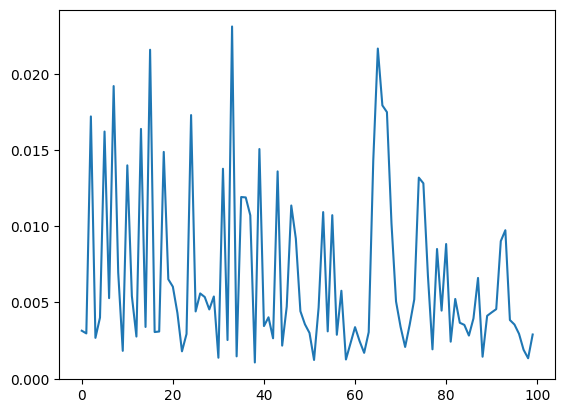

In [64]:
plt.plot(loss)